<i><span style="color:#e74c3c;"><b>MAIN GOAL: </b> I tried to classify a depressive or a non-depressive tweet using a FNet (Mixing Tokens with Fourier Transforms) [1] model.</span></i>


* I applied several <b>preprocessing</b> operations (cleaning,dropping stop words etc.),
* Used <b>tf.data pipeline</b> for efficient training,
* I created <b>Vocabulary</b> and trained <b>Tokenizer</b> using the train data,
* 5 KFold <b>cross validation</b>,
* I have modified this notebook [2],

## Proposed Model
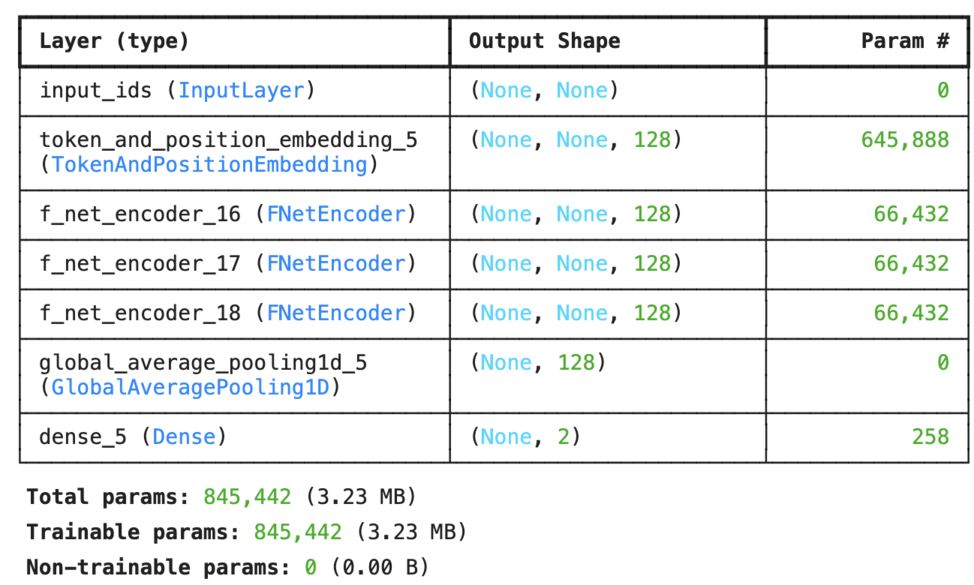

## My Another Projects
* [Yelp Review Stars Prediction w/Gemma 7B (LoRA)](https://www.kaggle.com/code/banddaniel/yelp-review-stars-prediction-w-gemma-7b-lora)
* [News Zero-Shot Topic Modelling w/BERTopic](https://www.kaggle.com/code/banddaniel/news-zero-shot-topic-modelling-w-bertopic)
* [Complaint Analysis w/Ensemble Model (CatBoost, LR)](https://www.kaggle.com/code/banddaniel/complaint-analysis-w-ensemble-model-catboost-lr)


## References
1. Lee-Thorp, J., Ainslie, J., Eckstein, I., & Ontanon, S. (2021). FNet: Mixing Tokens with Fourier Transforms (Version 4). arXiv. https://doi.org/10.48550/ARXIV.2105.03824
2. https://keras.io/examples/nlp/fnet_classification_with_keras_nlp/

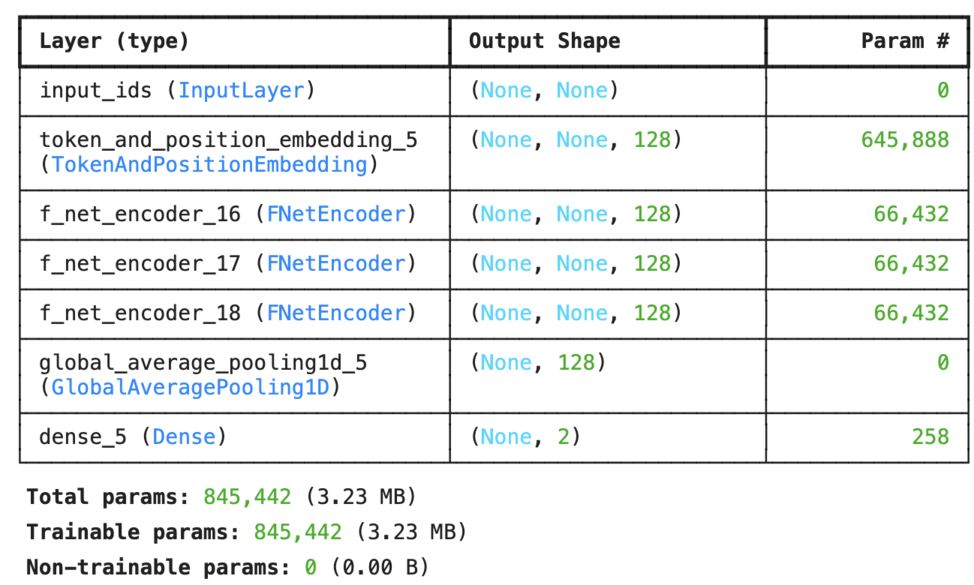

In [1]:
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import *
import keras_nlp
from keras_nlp.layers import *
from tensorflow.keras.models import Model

SEED = 99
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE

VOCAB_SIZE = 5000
EMBED_DIM = 128
INTERMEDIATE_DIM = 256

2024-04-12 21:47:38.750720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 21:47:38.750815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 21:47:38.880254: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# <span style="color:#e74c3c;"> Reading </span> Data

In [2]:
# reading, dropping and shuffling
data = pd.read_csv('/kaggle/input/depressivenon-depressive-tweets-data/clean_tweet_Dec19ToDec20.csv')
data.drop_duplicates(subset = ['text'], inplace = True)
data = data.sample(frac = 1, random_state = SEED).reset_index(drop = True)
data.head()

,Unnamed: 0,text,sentiment
0,50598,sad to say dislike rachel koo little more afte...,1
1,127113,gotta have my coffee man,0
2,87969,what god has blessed no man can curse the bles...,1
3,82503,this is the first pride month that ve felt tot...,1
4,25944,believed death was broken department stores,0


# <span style="color:#e74c3c;"> Preprocessing </span>

In [3]:
%%time
# preprocessing functions
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
full_data = data.copy()
full_data['preprocessed_text'] = data['text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)

CPU times: user 9.28 s, sys: 15.9 ms, total: 9.29 s
Wall time: 9.3 s


In [4]:
# calculating max token numbers and dropping samples have 0,1 or 2 tokens
full_data['max']= full_data['preprocessed_text'].apply(lambda X: len(X.split()))

drop_idx = full_data[(full_data['max'] == 0) | (full_data['max'] == 1) | (full_data['max'] == 2)].index
full_data.drop(index = drop_idx, inplace = True)


# set the max sequence length of full dataset
MAX_SEQUENCE_LENGTH = full_data['max'].max()

print('final sample size: \t', full_data.shape[0])
print('max sequence length: \t', MAX_SEQUENCE_LENGTH)

final sample size: 	 121080
max sequence length: 	 46


In [5]:
# final dataframe
full_data.head()

,Unnamed: 0,text,sentiment,preprocessed_text,max
0,50598,sad to say dislike rachel koo little more afte...,1,sad say dislike rachel koo little episode grea...,14
1,127113,gotta have my coffee man,0,gotta coffee man,3
2,87969,what god has blessed no man can curse the bles...,1,god blessed man curse blessing god powerful be...,20
3,82503,this is the first pride month that ve felt tot...,1,first pride month felt totally confident ident...,11
4,25944,believed death was broken department stores,0,believed death broken department stores,5


# <span style="color:#e74c3c;"> Dataset </span> Splitting

In [6]:
# train,validation and test splitting

train_val_data, test_data = train_test_split(full_data, test_size = 0.2, random_state = SEED, stratify = full_data['sentiment'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.2, random_state = SEED, stratify = train_val_data['sentiment'])


train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 77491
val samples :	 19373
test samples :	 24216


# <span style="color:#e74c3c;"> Create </span> Vocabulary and Tokenizer

In [7]:
%%time
train_dataset_for_vocab = tf.data.Dataset.from_tensor_slices(train_data['preprocessed_text'].values)
reserved_tokens = ["[PAD]", "[UNK]"]

# creating vocabulary
vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(train_dataset_for_vocab, VOCAB_SIZE, reserved_tokens = reserved_tokens)

# creating tokenizer
tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(vocabulary = vocab, lowercase = True, sequence_length = MAX_SEQUENCE_LENGTH)

CPU times: user 4min 25s, sys: 4.28 s, total: 4min 30s
Wall time: 4min 21s


# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [8]:
# a function for tf.data pipeline
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

In [9]:
# tf.datasets

test_loader = tf.data.Dataset.from_tensor_slices((test_data['preprocessed_text'], test_data['sentiment']))
test_dataset = (test_loader.map(format_dataset, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))

# <span style="color:#e74c3c;"> FNet </span>  Model

In [10]:
inp = Input(shape=(None,), dtype=tf.int64, name = "input_ids")
emb = TokenAndPositionEmbedding(vocabulary_size = VOCAB_SIZE, sequence_length = MAX_SEQUENCE_LENGTH, embedding_dim = EMBED_DIM, mask_zero = True)(inp)

X = FNetEncoder(INTERMEDIATE_DIM, 0.1, activation = 'gelu')(emb)
X = FNetEncoder(INTERMEDIATE_DIM, 0.1, activation = 'gelu')(X)
X = FNetEncoder(INTERMEDIATE_DIM, activation = 'gelu')(X)

X = GlobalAveragePooling1D()(X)
out = Dense(2, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.AdamW(learning_rate=4e-04, weight_decay = 0.005), metrics = ['acc'])

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience = 5, min_delta = 0.001, monitor = 'val_loss'),
                tf.keras.callbacks.ModelCheckpoint('/kaggle/working/fnet_model.best.weights.h5', save_best_only=True, save_weights_only=True)]
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'f_net_encoder' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)          │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, None, 128)      │       645,888 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder (FNetEncoder)     │ (None, None, 128)      │        66,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder_1 (FNetEncoder)   │ (None, None, 128)      │        66,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ f_net_encoder_2 (FNetEncoder)   │ (None, None, 128)      │        66,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845,442 (3.23 MB)

 Trainable params: 845,442 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

# <span style="color:#e74c3c;"> 5 KFold </span>  Training

In [11]:
fold_hists = []
test_preds = []

FOLDS = 5
EPOCHS = 8


kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
for i,(train_index, val_index) in enumerate(kf.split(train_data['preprocessed_text'], train_data['sentiment'])):
    print('-'*90)
    print(str(i+1) + '.fold training\n')
    
    X_train_fold = train_data['preprocessed_text'][train_index]
    y_train_fold = train_data['sentiment'][train_index]

    X_val_fold = train_data['preprocessed_text'][val_index]
    y_val_fold = train_data['sentiment'][val_index]
    
    # tf.data datasets
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader.map(format_dataset, num_parallel_calls = AUTO).shuffle(BATCH_SIZE*10).batch(BATCH_SIZE).prefetch(AUTO))
    
    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader.map(format_dataset, num_parallel_calls = AUTO).batch(BATCH_SIZE).prefetch(AUTO))
    
    # training
    hist = model.fit(train_dataset, epochs = EPOCHS, validation_data = validation_dataset, callbacks = my_callbacks)
    fold_hists.append(hist)
    
    # test predictions
    pred_ = model.predict(test_dataset)
    pred = np.argmax(pred_, axis = 1)
    test_preds.append(pred)

------------------------------------------------------------------------------------------
1.fold training

Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'position_embedding' (of type PositionEmbedding) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:845: UserWarning: Layer 'f_net_encoder' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  1/969 ━━━━━━━━━━━━━━━━━━━━ 3:04:23 11s/step - acc: 0.5625 - loss: 0.7042

I0000 00:00:1712958754.105895      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712958754.287314      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712958754.292587      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712958754.294010      66 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


969/969 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.6999 - loss: 0.5265

W0000 00:00:1712958766.155668      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712958766.156910      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712958766.158079      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


969/969 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - acc: 0.7000 - loss: 0.5264 - val_acc: 0.8804 - val_loss: 0.2941
Epoch 2/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - acc: 0.9003 - loss: 0.2559 - val_acc: 0.8768 - val_loss: 0.3195
Epoch 3/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - acc: 0.9304 - loss: 0.1918 - val_acc: 0.8718 - val_loss: 0.3679
Epoch 4/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - acc: 0.9568 - loss: 0.1257 - val_acc: 0.8561 - val_loss: 0.5147
Epoch 5/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - acc: 0.9739 - loss: 0.0777 - val_acc: 0.8660 - val_loss: 0.5413
Epoch 6/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - acc: 0.9815 - loss: 0.0532 - val_acc: 0.8570 - val_loss: 0.6496
379/379 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
------------------------------------------------------------------------------------------
2.fold training

Epoch 1/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.9481 - loss: 0.1646

W0000 00:00:1712958830.625891      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712958830.627170      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712958830.628425      67 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


969/969 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - acc: 0.9481 - loss: 0.1646 - val_acc: 0.9630 - val_loss: 0.1015
Epoch 2/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - acc: 0.9820 - loss: 0.0602 - val_acc: 0.9553 - val_loss: 0.1257
Epoch 3/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - acc: 0.9892 - loss: 0.0335 - val_acc: 0.9475 - val_loss: 0.1713
Epoch 4/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - acc: 0.9897 - loss: 0.0292 - val_acc: 0.9305 - val_loss: 0.2483
Epoch 5/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - acc: 0.9901 - loss: 0.0274 - val_acc: 0.9281 - val_loss: 0.2923
Epoch 6/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - acc: 0.9919 - loss: 0.0223 - val_acc: 0.9311 - val_loss: 0.2827
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
------------------------------------------------------------------------------------------
3.fold training

Epoch 1/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - acc: 0.9772 - loss: 0.0693 - val_acc: 0.9870 - val_loss: 0.0379
Epoch 2/8
969/969 ━━━━━━━━━━━━━━━━━━━━ 1

# <span style="color:#e74c3c;"> Final </span>  Test Predictions

In [12]:
# Calculating the mean of 5 folds predictions
preds = np.mean(test_preds, axis = 0)
last_pred = np.round(preds)

# <span style="color:#e74c3c;"> Test </span>  Results

In [13]:
# a function for calculating and plotting predictions 
def plot_prediction_results(y_true: np.array, y_pred : np.array) -> None:
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = ['depressive', 'non-depressive'])
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = ['depressive', 'non-depressive'],  xticks_rotation="vertical", values_format = '2g', colorbar = False)

Mean Squared Error :	0.11839
Weighted F1 Score :	0.882
Accuracy Score :	88.161 %
----------------------------------------------------------------------

 Classification Report:
                 precision    recall  f1-score   support

    depressive       0.88      0.87      0.88     11743
non-depressive       0.88      0.89      0.89     12473

      accuracy                           0.88     24216
     macro avg       0.88      0.88      0.88     24216
  weighted avg       0.88      0.88      0.88     24216

----------------------------------------------------------------------

 Confusion Matrix: 



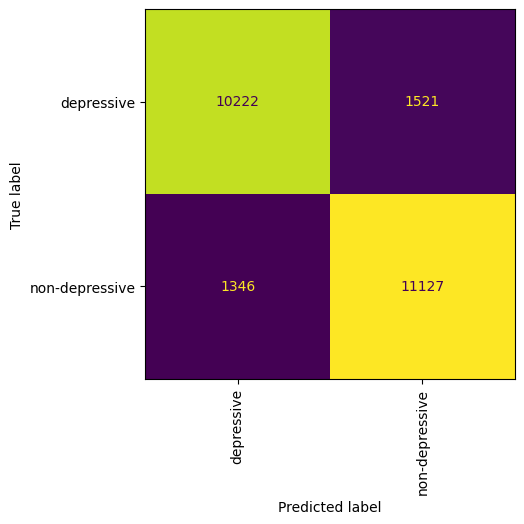

In [14]:
# I considered the 0 class as depressive and the 1 class as non-depressive.
plot_prediction_results(test_data['sentiment'], last_pred)